# Class 5: Error estimates

In this class we will review methods to determine statistical errors by re-sampling data, Monte Carlo simulations or error propagation.  At the end of these activities you should be able to:

- generate errors through re-sampling the data using bootstrap or jack-knife procedures
- propagate errors in different quantities in linear or non-linear combinations
- use Fisher matrices to forecast parameter errors
- model errors using Monte Carlo simulations

Often we have no analytic model for the statistics we estimate from our data.  However, we can still determine errors in these statistics using **approximate sampling procedures**.

The basic idea is to build up many _statistical realizations_ of the data by random re-sampling, and use the **scatter across these realizations** to estimate the error.

## Jack-knife errors

The **jack-knife procedure** allows us to estimate the error in a statistic by re-sampling the data (without replacement):

- Given a dataset with $N$ entries, we create $N$ separate datasets, deleting 1 entry in turn
- We measure the statistic for each of these datasets, creating $N$ measurements $S_i$
- The jack-knife error $= \sqrt{N-1} \times \sigma(S_i)$

The factor $\sqrt{N-1}$ is required since the $S_i$ are correlated with each other, given that the datasets $D_i$ all significantly overlap.

Let's apply this procedure to the problem of fitting the straight line from Class 3.  Here are the 10 jack-knife samples and best fits:

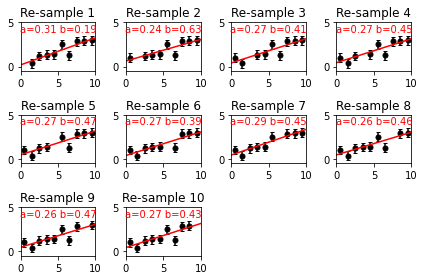

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

# Function which evaluates the chi-squared value of a model y=a*x+b for an (x,y) dataset
def chisqstraightline2(p,x,y,yerr):
  a,b = p[0],p[1]
  return np.sum(((y - (a*x + b))/yerr)**2)

# Read in the example dataset sampled from a straight line
# You will need to change the file path to the location where you've saved the data
data = np.loadtxt('../datasets/straightline.dat')
x,y,yerr = data[:,0],data[:,1],data[:,2]
nx = len(x)
# The number of jack-knife samples is equal to the number of data points, we use separate variables for clarity
nsamp = nx

# For each jack-knife sample, we exclude one of the data points in turn
# We loop over jack-knife samples, plotting the best-fit in each case
fig = plt.figure()
xmin,xmax = 0.,10.
ymin,ymax = -0.5,5.
asamp,bsamp = np.empty(nsamp),np.empty(nsamp)
for isamp in range(nsamp):
# Select jack-knife sample by removing each data point in turn
  cut = [np.arange(nx) != isamp]
  x1,y1,y1err = x[tuple(cut)],y[tuple(cut)],yerr[tuple(cut)]
# Fit straight line to data by minimising the chi-squared value
  a0,b0 = 0.2,1. # initial guess (result should not depend on this)
  p0 = [a0,b0]
  result = minimize(chisqstraightline2,p0,args=(x1,y1,y1err))
# Best-fitting values of straight line model parameters a,b for this sample
  a1,b1 = result['x']
  asamp[isamp],bsamp[isamp] = a1,b1
# Plot each sample and best fit
  sub = fig.add_subplot(3,4,isamp+1)
  plt.plot(x1,y1,marker='o',markersize=5,color='black',linestyle='None')
  plt.errorbar(x1,y1,yerr=y1err,color='black',capsize=2.,linestyle='None')
  plt.plot([xmin,xmax],[a1*xmin+b1,a1*xmax+b1],color='red')
  plt.title('Re-sample ' + str(isamp+1))
  plt.xlim(xmin,xmax)
  plt.ylim(ymin,ymax)
  xc,yc = 0.5*(xmin+xmax),ymin+0.8*(ymax-ymin)
  caption = 'a=' + '{:4.2f}'.format(a1) + ' b=' + '{:4.2f}'.format(b1)
  plt.text(xc,yc,caption,horizontalalignment='center',color='red',fontsize=10)
fig.tight_layout()

And here are the best fits of $(a,b)$ for each of those samples, compared to the original $\chi^2$ contours:

Text(0, 0.5, '$b$')

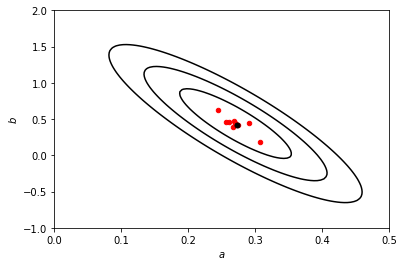

In [2]:
# Determine chi-squared across the 2D parameter grid (code is the same as Class 3)
amin,amax,na = 0.,0.5,100
bmin,bmax,nb = -1.,2.,100
da,db = (amax-amin)/na,(bmax-bmin)/nb
alst = np.linspace(amin+0.5*da,amax-0.5*da,na)
blst = np.linspace(bmin+0.5*db,bmax-0.5*db,nb)
chisq2 = np.empty((na,nb))
for i in range(na):
  for j in range(nb):
    chisq2[i,j] = chisqstraightline2([alst[i],blst[j]],x,y,yerr)
minchisq = np.amin(chisq2)
i,j = np.unravel_index(chisq2.argmin(),chisq2.shape)
a,b = alst[i],blst[j]
alst2,blst2 = np.meshgrid(alst,blst,indexing='ij')

# Plot the best-fitting values of the parameters from each jack-knife sample
# Also plot the (1-sigma, 2-sigma, 3-sigma) contour values of chi-squared (code is the same as Class 3)
clst = np.array([0.,2.30,6.17,11.8])
clst += minchisq
plt.contour(alst2,blst2,chisq2,levels=clst,colors='k')
plt.plot([a],[b],marker='o',markersize=5,color='black',linestyle='None')
plt.scatter(asamp,bsamp,marker='o',s=20,color='red')
plt.xlim(amin,amax)
plt.ylim(bmin,bmax)
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')

We can compare the estimated jack-knife errors with the errors obtained from the $\chi^2$ contours:

In [3]:
from scipy import stats

# Jack-knife error is the standard deviation of the best-fitting parameters to the samples, scaled by \sqrt(nsamp-1)
norm = np.sqrt(float(nsamp-1))
s = stats.describe(asamp)
print('Jack-knife error in a =',norm*np.sqrt(s.variance))
s = stats.describe(bsamp)
print('Jack-knife error in b =',norm*np.sqrt(s.variance))

# For comparison, we determine the error in the parameters using the chi-squared method (code is the same as Class 3)
# The different determinations of the error agree well
chisqa = np.amin(chisq2,axis=0)
chisqb = np.amin(chisq2,axis=1)
i = chisqa.argmin()
abot = np.interp(minchisq+1.,np.flip(chisqa[:i]),np.flip(alst[:i]))
atop = np.interp(minchisq+1.,chisqa[i:],alst[i:])
i = chisqb.argmin()
bbot = np.interp(minchisq+1.,np.flip(chisqb[:i]),np.flip(blst[:i]))
btop = np.interp(minchisq+1.,chisqb[i:],blst[i:])
asig = 0.5*(atop-abot)
bsig = 0.5*(btop-bbot)
print('Chi-squared error in a =',asig)
print('Chi-squared error in b =',bsig)

Jack-knife error in a = 0.05193629364182536
Jack-knife error in b = 0.3207081549826602
Chi-squared error in a = 0.05292881652401213
Chi-squared error in b = 0.33002843260768994


In some situations, the jack-knife samples could be created by deleting **regions** or **groups of points**, not individual points.

## Bootstrap errors

The **bootstrap procedure** is another method for estimating errors by re-sampling the data.  If we have $N$ data points, the procedure is:

- **Repeatedly draw samples of $N$ points at random, with replacement**
- Hence, the same point can appear multiple times in each bootstrap sample
- Measure the statistic for each of these bootstrap datasets (which can number $N_{samp} \gg N$), creating measurements $S_i$
- The bootstrap error is the standard deviation of $S_i$

Here's a bootstrap analysis of the straight line dataset:

Text(0, 0.5, '$b$')

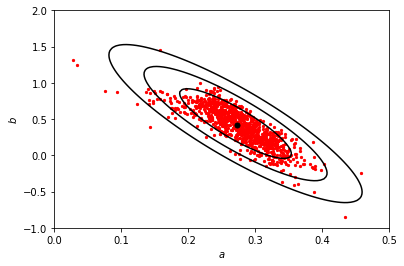

In [4]:
# Determine the errors in the model parameters by bootstrap re-sampling
nsamp = 1000 # Number of bootstrap samples (can be much greater than the number of data points)
asamp,bsamp = np.empty(nsamp),np.empty(nsamp)
for isamp in range(nsamp):
# Select a bootstrap sample using random sampling with replacement
  cut = np.random.choice(nx,nx,replace=True)
  x1,y1,y1err = x[cut],y[cut],yerr[cut]
# Fit straight line to each bootstrap sample
  p0 = [a0,b0]
  result = minimize(chisqstraightline2,p0,args=(x1,y1,y1err))
  a1,b1 = result['x']
# Save the best-fitting parameters for each bootstrap sample
  asamp[isamp],bsamp[isamp] = a1,b1

# Plot the original chi-squared contours, as well as the best fits for each bootstrap sample
# The two distributions should roughly agree
plt.contour(alst2,blst2,chisq2,levels=clst,colors='k')
plt.plot([a],[b],marker='o',markersize=5,color='black',linestyle='None')
plt.scatter(asamp,bsamp,marker='o',s=5,color='red')
plt.xlim(amin,amax)
plt.ylim(bmin,bmax)
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')

The estimated bootstrap errors are then:

In [5]:
# Bootstrap error is the standard deviation of the best-fitting parameters to the samples (no re-scaling needed)
s = stats.describe(asamp)
print('Bootstrap error in a =',np.sqrt(s.variance))
s = stats.describe(bsamp)
print('Bootstrap error in b =',np.sqrt(s.variance))

Bootstrap error in a = 0.04732010550152727
Bootstrap error in b = 0.2631568374178819


## Activity

In this Activity we will return to our previous analyses of Hubble and Lemaitre's distance-velocity datasets and determine **bootstrap errors** on our measurements:

- Find the bootstrap error in the correlation coefficient
- Find the bootstrap error in the slope $H_0$
- How do these compare to your previous measurements?

## Combining and propagating errors

A common situation in statistical analysis is, we have obtained measurements and errors of some variables, and need to determine the error in a function of those variables.

Consider for example a **linear function of independent variables** $(x,y)$ with coefficients $(a,b)$:

$z = a \, x + b \, y$

The variances combine as:

${\rm Var}(z) = a^2 \, {\rm Var}(x) + b^2 \, {\rm Var}(y)$

Now consider a **non-linear function of a single variable** $x$, $z = f(x)$.  An approximation of the propagated error at $x = x_0$ is:

$\sigma_z = | \frac{df}{dx} (x=x_0) | \times \sigma_x$

Finally, a **non-linear function of 2 independent variables**, $z = f(x,y)$:

${\rm Var}(z) = \left( \frac{\partial f}{\partial x} \right)^2 {\rm Var}(x) + \left( \frac{\partial f}{\partial y} \right)^2 {\rm Var}(y)$

## Activity

Here are a couple of examples to practice error propagation:

_A galaxy of absolute magnitude $M = -20$ is observed to have apparent magnitude $m = 20.0 \pm 0.2$.  Assuming $m - M = 5 \log_{10}(D_L) + 25$, what is the luminosity distance $D_L$ and its error?_

_The total mass of a binary star system (in $M_\odot$) is given by Kepler's law, $M = a^3/P^2$, where $a$ is the mean separation (in A.U.) and $P$ is the period (in years).  The $\alpha$ Centauri system has a period $P = 79.9 \pm 1.0$ years and mean separation $a = 23.7 \pm 1.0$ A.U.  What is the total mass and error?

## Fisher matrix

The **Fisher matrix** is a mathematical technique to propagate the statistical errors in a dataset to the errors in the model parameters describing the dataset.  The matrix is given by:

$F_{ij} = \sum_k \frac{\partial m_k}{\partial p_i} \frac{1}{\sigma_k^2} \frac{\partial m_k}{\partial p_j}$

where $i,j$ label the model parameters $p_i$, $k$ labels the $N$ data points, $\partial m_k/\partial p_i$ is the partial derivative of the model at point $k$, with respect to the parameter $p_i$, and $\sigma_k$ is the error in data point $k$.

After the Fisher matrix has been evaluated, the **covariance matrix of the parameters is then given by the inverse of the Fisher matrix**,

$C = F^{-1}$

The error in $p_i$ is then forecast as $\sqrt{C_{ii}}$.

## Monte Carlo simulations

A **Monte Carlo simulation** is a computer model of an experiment in which many random realizations of the results are created and analysed like the real data.  This allows us to determine the errors in our measurements as the **standard deviation of the fitted parameters over the realizations**.

## Activity

Run a Monte Carlo simulation of Hubble's distance-redshift investigation, and hence determine the error in $H_0$.